In [1]:
import pandas as pd
import geopandas
import folium 
import requests
import glob
import arrow
from collections import Counter
from folium import plugins
import arrow

In [2]:
list_files = glob.glob(r"..\data\\raw_tfl_data\*.csv")
list_files

['..\\data\\\\raw_tfl_data\\191JourneyDataExtract04Dec2019-10Dec2019.csv',
 '..\\data\\\\raw_tfl_data\\192JourneyDataExtract11Dec2019-17Dec2019.csv',
 '..\\data\\\\raw_tfl_data\\193JourneyDataExtract18Dec2019-24Dec2019.csv',
 '..\\data\\\\raw_tfl_data\\194JourneyDataExtract25Dec2019-31Dec2019.csv',
 '..\\data\\\\raw_tfl_data\\195JourneyDataExtract01Jan2020-07Jan2020.csv',
 '..\\data\\\\raw_tfl_data\\196JourneyDataExtract08Jan2020-14Jan2020.csv',
 '..\\data\\\\raw_tfl_data\\199JourneyDataExtract29Jan2020-04Feb2020.csv',
 '..\\data\\\\raw_tfl_data\\200JourneyDataExtract05Feb2020-11Feb2020.csv',
 '..\\data\\\\raw_tfl_data\\201JourneyDataExtract12Feb2020-18Feb2020.csv',
 '..\\data\\\\raw_tfl_data\\202JourneyDataExtract19Feb2020-25Feb2020.csv',
 '..\\data\\\\raw_tfl_data\\203JourneyDataExtract26Feb2020-03Mar2020.csv',
 '..\\data\\\\raw_tfl_data\\204JourneyDataExtract04Mar2020-10Mar2020.csv',
 '..\\data\\\\raw_tfl_data\\205JourneyDataExtract11Mar2020-17Mar2020.csv',
 '..\\data\\\\raw_tfl_dat

In [4]:
interim_container = []

for _file in list_files: 
    
    _data = pd.read_csv(_file)
    interim_container.append(_data)

combined_data = interim_container[0].append(interim_container[1:])

In [5]:
combined_data = combined_data.rename(columns = {"Start Date":"Start_Date", "End Date":"End_Date"})

In [6]:
combined_data["Start_Date_Converted"] = pd.to_datetime(combined_data["Start_Date"], format = "%d/%m/%Y %H:%M")
combined_data["End_Date_Converted"] = pd.to_datetime(combined_data["End_Date"], format = "%d/%m/%Y %H:%M")

In [7]:
combined_data = combined_data.sort_values(by="Start_Date_Converted")

In [8]:
combined_data.shape

(3401033, 11)

In [9]:
# lat_dict = {}
# lng_dict = {}

# for key, value in map_dict.items(): 
    
#     lat_dict[key] = value[0]
#     lng_dict[key] = value[1]
    
    

In [10]:
def data_request(station_name): 
    api_key = "INSERT API KEY HERE"
    r = requests.get(f"https://api.opencagedata.com/geocode/v1/json?q={station_name}&key={api_key}")
    return r.json()




In [11]:
start_station = (combined_data["StartStation Name"].to_list())
end_station = (combined_data["EndStation Name"].to_list())
combined_list_of_stations = start_station + end_station
all_stations = Counter(combined_list_of_stations)


In [13]:
lat_dict = {}
lng_dict ={}

for key in all_stations.keys(): 

    data = data_request(key)

    try:
        
        if data["results"][0]["components"]["city"] == "London":
            
            print (data["results"][0])
            lat = data["results"][0]["geometry"]["lat"]
            lng = data["results"][0]["geometry"]["lng"]
        
        else: 
            
            lat = None 
            lng = None 
        
    except KeyError: 
        
        lat = None 
        lng = None
        
    except IndexError: 
        
        lat = None 
        lng = None        
    
    else: 
        
        lat_dict[key] = lat
        lng_dict[key] = lng
        
    print (len(lat_dict))

{'annotations': {'DMS': {'lat': "51° 30' 26.84412'' N", 'lng': "0° 5' 57.63732'' E"}, 'MGRS': '30UYC0129010247', 'Maidenhead': 'IO91wm81bs', 'Mercator': {'x': -11058.885, 'y': 6678087.805}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=24642569#map=17/51.50746/-0.09934', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.50746/-0.09934&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50746&mlon=-0.09934#map=17/51.50746/-0.09934'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvj8xstju4bnc8528f', 'qibla': 119.02, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 29' 14.25228'' N", 'lng': "0° 7' 27.75720'' E"}, 'MGRS': '30UXC9964107937', 'Maidenhead': 'IO91wl56bw', 'Mercator': {'x': -13845.583, 'y': 6674491.58}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=32998733#map=17/51.48729/-0.12438', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.48729/-0.12438&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.48729&mlon=-0.12438#map=17/51.48729/-0.12438'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuvhvrjycy1x0ps7p6', 'qibla': 118.97, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 29' 10.37688'' N", 'lng': "0° 9' 55.28052'' E"}, 'MGRS': '30UXC9680107706', 'Maidenhead': 'IO91wl06dq', 'Mercator': {'x': -18407.312, 'y': 6674299.626}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=450284506#map=17/51.48622/-0.16536', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.48622/-0.16536&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.48622&mlon=-0.16536#map=17/51.48622/-0.16536'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuuhz8fymb7765b1xv', 'qibla': 118.93, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 30' 22.80852'' N", 'lng': "0° 7' 54.92388'' E"}, 'MGRS': '30UXC9903410034', 'Maidenhead': 'IO91wm41em', 'Mercator': {'x': -14685.635, 'y': 6677887.846}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=38446963#map=16/51.50634/-0.13192', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.50634/-0.13192&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50634&mlon=-0.13192#map=16/51.50634/-0.13192'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvhbryjuyu5rqrk76u', 'qibla': 118.98, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 32' 0.25224'' N", 'lng': "0° 7' 7.03488'' E"}, 'MGRS': '30UXC9983913079', 'Maidenhead': 'IO91wm58sa', 'Mercator': {'x': -13204.807, 'y': 6682717.663}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=500005091#map=16/51.53340/-0.11862', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.53340/-0.11862&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.53340&mlon=-0.11862#map=16/51.53340/-0.11862'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvjm3egftvm7qf461b', 'qibla': 119.02, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 29' 11.11272'' N", 'lng': "0° 13' 26.84424'' E"}, 'MGRS': '30UXC9272107573', 'Maidenhead': 'IO91vl36cr', 'Mercator': {'x': -24949.303, 'y': 6674336.071}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=512856679#map=17/51.48642/-0.22412', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.48642/-0.22412&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.48642&mlon=-0.22412#map=17/51.48642/-0.22412'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpufuuf1s37xkgb7du5', 'qibla': 118.86, 'roadinfo': {'drive_on': 

{'annotations': {'DMS': {'lat': "51° 29' 30.42348'' N", 'lng': "0° 13' 44.45328'' E"}, 'MGRS': '30UXC9235908156', 'Maidenhead': 'IO91vl28ma', 'Mercator': {'x': -25493.811, 'y': 6675292.564}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=312263560#map=16/51.49178/-0.22901', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.49178/-0.22901&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49178&mlon=-0.22901#map=16/51.49178/-0.22901'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpufvc1rs61y009tjcx', 'qibla': 118.86, 'roadinfo': {'drive_on': 

{'annotations': {'DMS': {'lat': "51° 28' 52.08672'' N", 'lng': "0° 19' 48.22392'' E"}, 'MGRS': '30UXC8538906711', 'Maidenhead': 'IO91ul05jl', 'Mercator': {'x': -36742.356, 'y': 6673393.795}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=5081415#map=17/51.48114/-0.33006', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.48114/-0.33006&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.48114&mlon=-0.33006#map=17/51.48114/-0.33006'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpub7zekgpv3hst20xd', 'qibla': 118.74, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 29' 28.93308'' N", 'lng': "0° 5' 47.06592'' E"}, 'MGRS': '30UYC0156508467', 'Maidenhead': 'IO91wl87kw', 'Mercator': {'x': -10732.0, 'y': 6675218.738}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=6338822997#map=17/51.49137/-0.09641', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.49137/-0.09641&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49137&mlon=-0.09641#map=17/51.49137/-0.09641'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuvv9ycx1s4sekgw0v', 'qibla': 119.01, 'roadinfo': {'drive_on': '

36
{'annotations': {'DMS': {'lat': "51° 29' 52.36188'' N", 'lng': "0° 11' 1.80060'' E"}, 'MGRS': '30UXC9546908953', 'Maidenhead': 'IO91vl79wl', 'Mercator': {'x': -20464.252, 'y': 6676379.344}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=862179889#map=16/51.49788/-0.18383', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.49788/-0.18383&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49788&mlon=-0.18383#map=16/51.49788/-0.18383'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpugyfhuk7ccu4dejbj', 'qibla': 118.92, 'roadinfo': {'drive_on

{'annotations': {'DMS': {'lat': "51° 31' 56.31924'' N", 'lng': "0° 1' 58.65708'' E"}, 'MGRS': '30UYC0578313196', 'Maidenhead': 'IO91xm67bs', 'Mercator': {'x': -3669.124, 'y': 6682522.667}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=37804516#map=16/51.53231/-0.03296', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.53231/-0.03296&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.53231&mlon=-0.03296#map=16/51.53231/-0.03296'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvpjpvrzp02dg3qd3c', 'qibla': 119.12, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 28' 38.62056'' N", 'lng': "0° 11' 20.84460'' E"}, 'MGRS': '30UXC9518906662', 'Maidenhead': 'IO91vl74hn', 'Mercator': {'x': -21053.132, 'y': 6672726.939}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=4422170#map=16/51.47739/-0.18912', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.47739/-0.18912&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.47739&mlon=-0.18912#map=16/51.47739/-0.18912'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpugenm91g7ce07yyb6', 'qibla': 118.89, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 29' 55.08384'' N", 'lng': "0° 10' 46.67916'' E"}, 'MGRS': '30UXC9575709049', 'Maidenhead': 'IO91vl89kq', 'Mercator': {'x': -19996.665, 'y': 6676514.194}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=140394196#map=16/51.49863/-0.17963', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.49863/-0.17963&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49863&mlon=-0.17963#map=16/51.49863/-0.17963'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpugzj1q1rb5q0fmew6', 'qibla': 118.92, 'roadinfo': {'drive_on': 

{'annotations': {'DMS': {'lat': "51° 31' 50.78424'' N", 'lng': "0° 3' 1.11024'' E"}, 'MGRS': '30UYC0458712976', 'Maidenhead': 'IO91xm37xj', 'Mercator': {'x': -5600.305, 'y': 6682248.253}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=800854403#map=17/51.53077/-0.05031', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.53077/-0.05031&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.53077&mlon=-0.05031#map=17/51.53077/-0.05031'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvnugke8rkfc65tbh9', 'qibla': 119.09, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 31' 5.18664'' N", 'lng': "0° 6' 44.49744'' E"}, 'MGRS': '30UYC0034011396', 'Maidenhead': 'IO91wm64mi', 'Mercator': {'x': -12507.903, 'y': 6679987.971}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=3076573915#map=17/51.51811/-0.11236', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.51811/-0.11236&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51811&mlon=-0.11236#map=17/51.51811/-0.11236'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvj6w4tz610mje7cqu', 'qibla': 119.01, 'roadinfo': {'drive_on': 

{'annotations': {'DMS': {'lat': "51° 27' 42.03576'' N", 'lng': "0° 11' 51.27360'' E"}, 'MGRS': '30UXC9466904892', 'Maidenhead': 'IO91vl60gt', 'Mercator': {'x': -21994.06, 'y': 6669925.414}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=45830104#map=17/51.46168/-0.19758', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.46168/-0.19758&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.46168&mlon=-0.19758#map=17/51.46168/-0.19758'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpug821upudm42m28t9', 'qibla': 118.87, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 31' 9.45732'' N", 'lng': "0° 7' 40.86372'' E"}, 'MGRS': '30UXC9924911485', 'Maidenhead': 'IO91wm44pp', 'Mercator': {'x': -14250.868, 'y': 6680199.634}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?relation=177044#map=17/51.51929/-0.12802', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.51929/-0.12802&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51929&mlon=-0.12802#map=17/51.51929/-0.12802'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvj4fc8urj6jmd7fvh', 'qibla': 119.0, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 30' 23.12928'' N", 'lng': "0° 12' 30.55104'' E"}, 'MGRS': '30UXC9372209838', 'Maidenhead': 'IO91vm41xn', 'Mercator': {'x': -23208.6, 'y': 6677903.74}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=6708146798#map=17/51.50642/-0.20849', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.50642/-0.20849&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50642&mlon=-0.20849#map=17/51.50642/-0.20849'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpv522ntvmr8xx1t7xd', 'qibla': 118.9, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 31' 7.87368'' N", 'lng': "0° 3' 10.58976'' E"}, 'MGRS': '30UYC0445811643', 'Maidenhead': 'IO91xm34pm', 'Mercator': {'x': -5893.432, 'y': 6680121.151}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=687847192#map=17/51.51885/-0.05294', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.51885/-0.05294&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51885&mlon=-0.05294#map=17/51.51885/-0.05294'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvnf9rn67vs5rp80kf', 'qibla': 119.08, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 28' 56.40672'' N", 'lng': "0° 8' 10.57848'' E"}, 'MGRS': '30UXC9883707353', 'Maidenhead': 'IO91wl35ps', 'Mercator': {'x': -15169.707, 'y': 6673607.736}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=4715048896#map=16/51.48234/-0.13627', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.48234/-0.13627&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.48234&mlon=-0.13627#map=16/51.48234/-0.13627'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuuuhf2du7sjw6f9nv', 'qibla': 118.95, 'roadinfo': {'drive_on':

{'annotations': {'DMS': {'lat': "51° 31' 57.06192'' N", 'lng': "0° 7' 10.55532'' E"}, 'MGRS': '30UXC9977512978', 'Maidenhead': 'IO91wm57pt', 'Mercator': {'x': -13313.666, 'y': 6682559.488}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=584351058#map=17/51.53252/-0.11960', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.53252/-0.11960&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.53252&mlon=-0.11960#map=17/51.53252/-0.11960'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvjm0ytjkwzygebfnd', 'qibla': 119.02, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 27' 46.22148'' N", 'lng': "0° 12' 50.40036'' E"}, 'MGRS': '30UXC9352404978', 'Maidenhead': 'IO91vl41hb', 'Mercator': {'x': -23822.382, 'y': 6670132.617}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=3576223#map=16/51.46284/-0.21400', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.46284/-0.21400&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.46284&mlon=-0.21400#map=16/51.46284/-0.21400'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpug0s0v2tfnenzwc2e', 'qibla': 118.85, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 31' 41.29212'' N", 'lng': "0° 5' 29.81292'' E"}, 'MGRS': '30UYC0173512568', 'Maidenhead': 'IO91wm96as', 'Mercator': {'x': -10198.502, 'y': 6681777.674}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=649331890#map=16/51.52814/-0.09161', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.52814/-0.09161&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.52814&mlon=-0.09161#map=16/51.52814/-0.09161'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvjumm1hzhk07qxvs3', 'qibla': 119.05, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 30' 23.76324'' N", 'lng': "0° 9' 6.46200'' E"}, 'MGRS': '30UXC9765410009', 'Maidenhead': 'IO91wm11so', 'Mercator': {'x': -16897.742, 'y': 6677935.153}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=14197830#map=17/51.50660/-0.15180', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.50660/-0.15180&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50660&mlon=-0.15180#map=17/51.50660/-0.15180'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvh83rwym6nnyfrxe5', 'qibla': 118.96, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 30' 55.11060'' N", 'lng': "0° 3' 31.28436'' E"}, 'MGRS': '30UYC0407511233', 'Maidenhead': 'IO91xm23wq', 'Mercator': {'x': -6533.352, 'y': 6679488.585}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=5596959#map=17/51.51531/-0.05869', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.51531/-0.05869&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51531&mlon=-0.05869#map=17/51.51531/-0.05869'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvndj62mt3pdm26472', 'qibla': 119.07, 'roadinfo': {'drive_on': 'lef

{'annotations': {'DMS': {'lat': "51° 28' 32.23200'' N", 'lng': "0° 10' 31.23120'' E"}, 'MGRS': '30UXC9615406501', 'Maidenhead': 'IO91vl84xd', 'Mercator': {'x': -19518.982, 'y': 6672410.592}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=114395312#map=16/51.47562/-0.17534', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.47562/-0.17534&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.47562&mlon=-0.17534#map=16/51.47562/-0.17534'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuu4b74pp9bym0zpv3', 'qibla': 118.91, 'roadinfo': {'drive_on': 

{'annotations': {'DMS': {'lat': "51° 30' 14.44968'' N", 'lng': "0° 6' 18.90432'' E"}, 'MGRS': '30UYC0089509848', 'Maidenhead': 'IO91wm70ix', 'Mercator': {'x': -11716.51, 'y': 6677473.673}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=1419168250#map=16/51.50401/-0.10525', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.50401/-0.10525&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50401&mlon=-0.10525#map=16/51.50401/-0.10525'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvj852ekp189cqnq2f', 'qibla': 119.01, 'roadinfo': {'drive_on': 

{'annotations': {'DMS': {'lat': "51° 30' 3.90384'' N", 'lng': "0° 5' 36.28500'' E"}, 'MGRS': '30UYC0172909555', 'Maidenhead': 'IO91wm80sg', 'Mercator': {'x': -10398.632, 'y': 6676951.166}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=6797794418#map=16/51.50108/-0.09341', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.50108/-0.09341&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50108&mlon=-0.09341#map=16/51.50108/-0.09341'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuvz7zx3fx4bmc29mw', 'qibla': 119.02, 'roadinfo': {'drive_on': 

{'annotations': {'DMS': {'lat': "51° 29' 24.72000'' N", 'lng': "0° 12' 54.31320'' E"}, 'MGRS': '30UXC9333208017', 'Maidenhead': 'IO91vl47ep', 'Mercator': {'x': -23943.375, 'y': 6675010.049}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=6914066285#map=16/51.49020/-0.21509', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.49020/-0.21509&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49020&mlon=-0.21509#map=16/51.49020/-0.21509'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpugje2hhgx030dzfvx', 'qibla': 118.87, 'roadinfo': {'drive_on'

{'annotations': {'DMS': {'lat': "51° 31' 6.80412'' N", 'lng': "0° 2' 5.48232'' E"}, 'MGRS': '30UYC0571411661', 'Maidenhead': 'IO91xm54tk', 'Mercator': {'x': -3880.174, 'y': 6680068.139}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=6868777095#map=17/51.51856/-0.03486', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.51856/-0.03486&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51856&mlon=-0.03486#map=17/51.51856/-0.03486'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvp4wt7g136dv6rzrz', 'qibla': 119.1, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 29' 37.84056'' N", 'lng': "0° 8' 51.82008'' E"}, 'MGRS': '30UXC9799208602', 'Maidenhead': 'IO91wl28gm', 'Mercator': {'x': -16444.983, 'y': 6675659.973}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=159391530#map=17/51.49384/-0.14773', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.49384/-0.14773&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49384&mlon=-0.14773#map=17/51.49384/-0.14773'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuuwhmmsq5vmkmzy7c', 'qibla': 118.95, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 29' 31.82388'' N", 'lng': "0° 8' 48.08292'' E"}, 'MGRS': '30UXC9807108419', 'Maidenhead': 'IO91wl28jc', 'Mercator': {'x': -16329.423, 'y': 6675361.932}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=637020506#map=16/51.49217/-0.14669', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.49217/-0.14669&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49217&mlon=-0.14669#map=16/51.49217/-0.14669'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuutv5tuu4prm2rrqn', 'qibla': 118.95, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 31' 36.68232'' N", 'lng': "0° 7' 37.01568'' E"}, 'MGRS': '30UXC9929012329', 'Maidenhead': 'IO91wm46sk', 'Mercator': {'x': -14131.876, 'y': 6681549.15}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=803099035#map=17/51.52686/-0.12695', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.52686/-0.12695&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.52686&mlon=-0.12695#map=17/51.52686/-0.12695'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvjh5t9yhjg9jg4gzk', 'qibla': 119.01, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 31' 33.73068'' N", 'lng': "0° 4' 19.59204'' E"}, 'MGRS': '30UYC0309712388', 'Maidenhead': 'IO91xm16if', 'Mercator': {'x': -8027.126, 'y': 6681402.831}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=5903804#map=16/51.52604/-0.07211', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.52604/-0.07211&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.52604&mlon=-0.07211#map=16/51.52604/-0.07211'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvnk52ztrdyskp9mj2', 'qibla': 119.07, 'roadinfo': {'drive_on': 'lef

{'annotations': {'DMS': {'lat': "51° 32' 5.90280'' N", 'lng': "0° 7' 24.21696'' E"}, 'MGRS': '30UXC9950113241', 'Maidenhead': 'IO91wm58ej', 'Mercator': {'x': -13736.113, 'y': 6682997.822}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=17691742#map=16/51.53497/-0.12339', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.53497/-0.12339&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.53497&mlon=-0.12339#map=16/51.53497/-0.12339'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvjjwhuxr06h0x7wwe', 'qibla': 119.02, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 30' 23.45616'' N", 'lng': "0° 7' 24.42648'' E"}, 'MGRS': '30UXC9962110077', 'Maidenhead': 'IO91wm51en', 'Mercator': {'x': -13742.592, 'y': 6677919.937}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=145344751#map=16/51.50652/-0.12345', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.50652/-0.12345&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50652&mlon=-0.12345#map=16/51.50652/-0.12345'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvj0qp5q7tmk4h0st7', 'qibla': 118.99, 'roadinfo': {'drive_on': '

149
149
{'annotations': {'DMS': {'lat': "51° 31' 31.11924'' N", 'lng': "0° 6' 55.84932'' E"}, 'MGRS': '30UYC0009012188', 'Maidenhead': 'IO91wm66db', 'Mercator': {'x': -12858.926, 'y': 6681273.377}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=3284233#map=17/51.52531/-0.11551', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.52531/-0.11551&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.52531&mlon=-0.11551#map=17/51.52531/-0.11551'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvj7gusq4exy8pz1t2', 'qibla': 119.02, 'roadinfo': {'drive_

{'annotations': {'DMS': {'lat': "51° 30' 4.12524'' N", 'lng': "0° 11' 7.92780'' E"}, 'MGRS': '30UXC9533709312', 'Maidenhead': 'IO91vm70rg', 'Mercator': {'x': -20653.718, 'y': 6676962.126}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=204575755#map=16/51.50115/-0.18554', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.50115/-0.18554&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50115&mlon=-0.18554#map=16/51.50115/-0.18554'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpugz2zutqtw6qd751k', 'qibla': 118.92, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 29' 58.44192'' N", 'lng': "0° 9' 57.23928'' E"}, 'MGRS': '30UXC9670609189', 'Maidenhead': 'IO91wl09cv', 'Mercator': {'x': -18467.881, 'y': 6676680.562}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=5038620#map=17/51.49957/-0.16590', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.49957/-0.16590&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49957&mlon=-0.16590#map=17/51.49957/-0.16590'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuuppnwr0hs9fefyrr', 'qibla': 118.94, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 30' 44.36676'' N", 'lng': "0° 1' 21.82980'' E"}, 'MGRS': '30UYC0658311002', 'Maidenhead': 'IO91xm72gw', 'Mercator': {'x': -2530.348, 'y': 6678956.136}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=681013288#map=16/51.51232/-0.02273', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.51232/-0.02273&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51232&mlon=-0.02273#map=16/51.51232/-0.02273'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvp3x3n34ymju9e1nc', 'qibla': 119.11, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 29' 56.40072'' N", 'lng': "0° 5' 48.29892'' E"}, 'MGRS': '30UYC0150709314', 'Maidenhead': 'IO91wl89js', 'Mercator': {'x': -10770.127, 'y': 6676579.435}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=734646009#map=16/51.49900/-0.09675', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.49900/-0.09675&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49900&mlon=-0.09675#map=16/51.49900/-0.09675'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuvz1e3t6nq0xw667m', 'qibla': 119.01, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 31' 5.45880'' N", 'lng': "0° 9' 49.56012'' E"}, 'MGRS': '30UXC9677411265', 'Maidenhead': 'IO91wm04ii', 'Mercator': {'x': -18230.426, 'y': 6680001.46}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=27175640#map=17/51.51818/-0.16377', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.51818/-0.16377&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51818&mlon=-0.16377#map=17/51.51818/-0.16377'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvh68epvqsnk4w1mxv', 'qibla': 118.96, 'roadinfo': {'drive_on': 'lef

{'annotations': {'DMS': {'lat': "51° 30' 32.10408'' N", 'lng': "0° 11' 42.78696'' E"}, 'MGRS': '30UXC9463210150', 'Maidenhead': 'IO91vm62nd', 'Mercator': {'x': -21731.635, 'y': 6678348.458}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=222519222#map=17/51.50892/-0.19522', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.50892/-0.19522&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50892&mlon=-0.19522#map=17/51.50892/-0.19522'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpv58cv5n4rncbmtv40', 'qibla': 118.91, 'roadinfo': {'drive_on': 

{'annotations': {'DMS': {'lat': "51° 31' 30.83052'' N", 'lng': "0° 8' 6.52092'' E"}, 'MGRS': '30UXC9872812126', 'Maidenhead': 'IO91wm36sb', 'Mercator': {'x': -15044.239, 'y': 6681259.065}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=839471769#map=16/51.52523/-0.13514', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.52523/-0.13514&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.52523&mlon=-0.13514#map=16/51.52523/-0.13514'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvhgvs4zhv3ce4rcn3', 'qibla': 119.0, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 28' 29.32644'' N", 'lng': "0° 10' 0.43140'' E"}, 'MGRS': '30UXC9675106435', 'Maidenhead': 'IO91vl93xw', 'Mercator': {'x': -18566.588, 'y': 6672266.719}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=4237868#map=16/51.47481/-0.16679', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.47481/-0.16679&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.47481&mlon=-0.16679#map=16/51.47481/-0.16679'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuu4ww98dgrj5110wr', 'qibla': 118.91, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 30' 55.33812'' N", 'lng': "0° 9' 57.53448'' E"}, 'MGRS': '30UXC9663210946', 'Maidenhead': 'IO91wm03bq', 'Mercator': {'x': -18477.009, 'y': 6679499.861}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=41690602#map=17/51.51537/-0.16598', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.51537/-0.16598&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51537&mlon=-0.16598#map=17/51.51537/-0.16598'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvh4p4u36fpfre06qb', 'qibla': 118.95, 'roadinfo': {'drive_on': 'l

190
{'annotations': {'DMS': {'lat': "51° 30' 4.21920'' N", 'lng': "0° 10' 48.85104'' E"}, 'MGRS': '30UXC9570409329', 'Maidenhead': 'IO91vm80ig', 'Mercator': {'x': -20063.824, 'y': 6676966.79}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=860209061#map=17/51.50117/-0.18024', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.50117/-0.18024&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50117&mlon=-0.18024#map=17/51.50117/-0.18024'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpugzsb04mcxfp2gy9c', 'qibla': 118.92, 'roadinfo': {'drive_on

{'annotations': {'DMS': {'lat': "51° 31' 26.38992'' N", 'lng': "0° 9' 46.62432'' E"}, 'MGRS': '30UXC9680511913', 'Maidenhead': 'IO91wm05ks', 'Mercator': {'x': -18139.645, 'y': 6681038.943}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=4390580#map=16/51.52400/-0.16295', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.52400/-0.16295&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.52400&mlon=-0.16295#map=16/51.52400/-0.16295'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvh79m4cnz0vvm7tcs', 'qibla': 118.96, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 29' 19.79664'' N", 'lng': "0° 7' 22.99512'' E"}, 'MGRS': '30UXC9972608112', 'Maidenhead': 'IO91wl57fh', 'Mercator': {'x': -13698.331, 'y': 6674766.186}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=670207105#map=17/51.48883/-0.12305', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.48883/-0.12305&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.48883&mlon=-0.12305#map=17/51.48883/-0.12305'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuvjq2hwh0urmmudxe', 'qibla': 118.98, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 29' 19.28976'' N", 'lng': "0° 8' 31.23636'' E"}, 'MGRS': '30UXC9841108045', 'Maidenhead': 'IO91wl27xg', 'Mercator': {'x': -15808.492, 'y': 6674741.079}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=74763335#map=17/51.48869/-0.14201', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.48869/-0.14201&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.48869&mlon=-0.14201#map=17/51.48869/-0.14201'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuuv0x6gv9542z7kcs', 'qibla': 118.95, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 28' 26.88492'' N", 'lng': "0° 10' 36.22800'' E"}, 'MGRS': '30UXC9606406333', 'Maidenhead': 'IO91vl83tt', 'Mercator': {'x': -19673.494, 'y': 6672145.826}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=4719941#map=17/51.47413/-0.17673', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.47413/-0.17673&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.47413&mlon=-0.17673#map=17/51.47413/-0.17673'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpugfx69fhtccnjtc7n', 'qibla': 118.9, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 31' 9.03324'' N", 'lng': "0° 7' 7.97376'' E"}, 'MGRS': '30UXC9988311497', 'Maidenhead': 'IO91wm54ro', 'Mercator': {'x': -13233.841, 'y': 6680178.632}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=4253657#map=17/51.51918/-0.11888', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.51918/-0.11888&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51918&mlon=-0.11888#map=17/51.51918/-0.11888'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvj6c2vy7rq1uggsct', 'qibla': 119.01, 'roadinfo': {'drive_on': 'left

217
{'annotations': {'DMS': {'lat': "51° 31' 18.72516'' N", 'lng': "0° 9' 53.60436'' E"}, 'MGRS': '30UXC9668011671', 'Maidenhead': 'IO91wm05ff', 'Mercator': {'x': -18355.482, 'y': 6680659.012}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=615072057#map=17/51.52187/-0.16489', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.52187/-0.16489&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.52187&mlon=-0.16489#map=17/51.52187/-0.16489'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvh5rbtu348gqz2s9w', 'qibla': 118.96, 'roadinfo': {'drive_on

{'annotations': {'DMS': {'lat': "51° 31' 0.75720'' N", 'lng': "0° 12' 18.01584'' E"}, 'MGRS': '30UXC9391911009', 'Maidenhead': 'IO91vm54jb', 'Mercator': {'x': -22820.985, 'y': 6679768.437}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=469778404#map=16/51.51688/-0.20500', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.51688/-0.20500&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51688&mlon=-0.20500#map=16/51.51688/-0.20500'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpv566ex1cts3pq7zk3', 'qibla': 118.91, 'roadinfo': {'drive_on': 

{'annotations': {'DMS': {'lat': "51° 31' 30.27792'' N", 'lng': "0° 4' 10.41780'' E"}, 'MGRS': '30UYC0327812289', 'Maidenhead': 'IO91xm16pa', 'Mercator': {'x': -7743.439, 'y': 6681231.672}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=570640822#map=16/51.52508/-0.06956', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.52508/-0.06956&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.52508&mlon=-0.06956#map=16/51.52508/-0.06956'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvn7v774ectu65nw6t', 'qibla': 119.07, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 30' 53.68572'' N", 'lng': "0° 3' 58.27824'' E"}, 'MGRS': '30UYC0355711168', 'Maidenhead': 'IO91xm23bn', 'Mercator': {'x': -7368.059, 'y': 6679417.968}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=847078262#map=16/51.51491/-0.06619', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.51491/-0.06619&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51491&mlon=-0.06619#map=16/51.51491/-0.06619'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvn6pb1ey253023jrv', 'qibla': 119.06, 'roadinfo': {'drive_on': '

233
{'annotations': {'DMS': {'lat': "51° 29' 0.45312'' N", 'lng': "0° 8' 50.85060'' E"}, 'MGRS': '30UXC9805607448', 'Maidenhead': 'IO91wl26ha', 'Mercator': {'x': -16415.005, 'y': 6673808.133}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=5885044833#map=17/51.48346/-0.14746', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.48346/-0.14746&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.48346&mlon=-0.14746#map=17/51.48346/-0.14746'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuusk8guqux5h6n45b', 'qibla': 118.94, 'roadinfo': {'drive_o

237
{'annotations': {'DMS': {'lat': "51° 28' 22.65564'' N", 'lng': "0° 8' 2.15448'' E"}, 'MGRS': '30UXC9904006317', 'Maidenhead': 'IO91wl33wm', 'Mercator': {'x': -14909.22, 'y': 6671936.415}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=6914066485#map=16/51.47296/-0.13393', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.47296/-0.13393&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.47296&mlon=-0.13393#map=16/51.47296/-0.13393'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuufq7xpjjyf8exkgq', 'qibla': 118.95, 'roadinfo': {'drive_on

{'annotations': {'DMS': {'lat': "51° 28' 15.78000'' N", 'lng': "0° 7' 34.49496'' E"}, 'MGRS': '30UXC9958206126', 'Maidenhead': 'IO91wl43ub', 'Mercator': {'x': -14053.93, 'y': 6671595.982}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=24209004#map=16/51.47105/-0.12625', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.47105/-0.12625&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.47105&mlon=-0.12625#map=16/51.47105/-0.12625'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuv4h0d5nhz4dn7q4q', 'qibla': 118.95, 'roadinfo': {'drive_on': 'le

245
{'annotations': {'DMS': {'lat': "51° 28' 32.33496'' N", 'lng': "0° 13' 5.42172'' E"}, 'MGRS': '30UXC9318006391', 'Maidenhead': 'IO91vl34td', 'Mercator': {'x': -24286.874, 'y': 6672415.69}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=3997470#map=17/51.47565/-0.21817', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.47565/-0.21817&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.47565&mlon=-0.21817#map=17/51.47565/-0.21817'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpug4c5khqss9em1vtd', 'qibla': 118.86, 'roadinfo': {'drive_on': 

249
{'annotations': {'DMS': {'lat': "51° 28' 59.09160'' N", 'lng': "0° 10' 40.81908'' E"}, 'MGRS': '30UXC9593707324', 'Maidenhead': 'IO91vl85pw', 'Mercator': {'x': -19815.459, 'y': 6673740.704}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=636275201#map=16/51.48308/-0.17801', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.48308/-0.17801&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.48308&mlon=-0.17801#map=16/51.48308/-0.17801'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpugunqsjvss17jyqf5', 'qibla': 118.91, 'roadinfo': {'drive_o

{'annotations': {'DMS': {'lat': "51° 28' 38.07336'' N", 'lng': "0° 9' 53.81208'' E"}, 'MGRS': '30UXC9686806710', 'Maidenhead': 'IO91wl04em', 'Mercator': {'x': -18361.905, 'y': 6672699.843}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=6037246108#map=16/51.47724/-0.16495', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.47724/-0.16495&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.47724&mlon=-0.16495#map=16/51.47724/-0.16495'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuu5pusmw10hjzqr3c', 'qibla': 118.92, 'roadinfo': {'drive_on':

{'annotations': {'DMS': {'lat': "51° 30' 7.84800'' N", 'lng': "0° 4' 27.20460'' E"}, 'MGRS': '30UYC0305609730', 'Maidenhead': 'IO91xm10cm', 'Mercator': {'x': -8262.522, 'y': 6677146.58}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=837172153#map=16/51.50218/-0.07422', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.50218/-0.07422&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50218&mlon=-0.07422#map=16/51.50218/-0.07422'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuyr9vyqnyw29f065p', 'qibla': 119.04, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 31' 3.78804'' N", 'lng': "0° 11' 3.84864'' E"}, 'MGRS': '30UXC9534411158', 'Maidenhead': 'IO91vm74ug', 'Mercator': {'x': -20527.581, 'y': 6679918.652}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=23192755#map=16/51.51772/-0.18440', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.51772/-0.18440&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51772&mlon=-0.18440#map=16/51.51772/-0.18440'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpv5f98rngeem74swm3', 'qibla': 118.93, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 31' 29.45172'' N", 'lng': "0° 5' 58.04916'' E"}, 'MGRS': '30UYC0120512181', 'Maidenhead': 'IO91wm85bx', 'Mercator': {'x': -11071.625, 'y': 6681190.717}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=6855539366#map=16/51.52485/-0.09946', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.52485/-0.09946&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.52485&mlon=-0.09946#map=16/51.52485/-0.09946'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvjez9fry8t79myebx', 'qibla': 119.03, 'roadinfo': {'drive_on':

{'annotations': {'DMS': {'lat': "51° 30' 13.34304'' N", 'lng': "0° 12' 57.17880'' E"}, 'MGRS': '30UXC9322009516', 'Maidenhead': 'IO91vm40cv', 'Mercator': {'x': -24031.986, 'y': 6677418.841}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=2376356131#map=17/51.50371/-0.21588', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.50371/-0.21588&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50371&mlon=-0.21588#map=17/51.50371/-0.21588'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpugpfycd9zygphsvt1', 'qibla': 118.89, 'roadinfo': {'drive_on'

{'annotations': {'DMS': {'lat': "51° 29' 14.03160'' N", 'lng': "0° 11' 10.18104'' E"}, 'MGRS': '30UXC9535307763', 'Maidenhead': 'IO91vl76pw', 'Mercator': {'x': -20723.392, 'y': 6674480.641}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=4422782#map=17/51.48723/-0.18616', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.48723/-0.18616&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.48723&mlon=-0.18616#map=17/51.48723/-0.18616'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpugubqy5ebrbr1ku62', 'qibla': 118.9, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 28' 35.80500'' N", 'lng': "0° 7' 5.09160'' E"}, 'MGRS': '30UYC0012506767', 'Maidenhead': 'IO91wl54tj', 'Mercator': {'x': -13144.717, 'y': 6672587.517}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=616211678#map=16/51.47661/-0.11808', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.47661/-0.11808&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.47661&mlon=-0.11808#map=16/51.47661/-0.11808'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuv7410806mw4czn5g', 'qibla': 118.97, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 31' 50.63844'' N", 'lng': "0° 5' 10.42692'' E"}, 'MGRS': '30UYC0209712872', 'Maidenhead': 'IO91wm97pj', 'Mercator': {'x': -9599.046, 'y': 6682241.024}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=227558478#map=16/51.53073/-0.08623', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.53073/-0.08623&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.53073&mlon=-0.08623#map=16/51.53073/-0.08623'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvnhchq8y7pnqv7k6f', 'qibla': 119.05, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 29' 33.97668'' N", 'lng': "0° 5' 37.54788'' E"}, 'MGRS': '30UYC0174208630', 'Maidenhead': 'IO91wl88rg', 'Mercator': {'x': -10437.683, 'y': 6675468.571}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=691413772#map=17/51.49277/-0.09376', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.49277/-0.09376&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49277&mlon=-0.09376#map=17/51.49277/-0.09376'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuvvgxphm12tbw2wq2', 'qibla': 119.01, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 29' 52.54152'' N", 'lng': "0° 11' 41.48520'' E"}, 'MGRS': '30UXC9470408930', 'Maidenhead': 'IO91vl69om', 'Mercator': {'x': -21691.382, 'y': 6676388.244}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=8392388#map=16/51.49793/-0.19486', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.49793/-0.19486&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49793&mlon=-0.19486#map=16/51.49793/-0.19486'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpugwfj5t85dck58xdz', 'qibla': 118.9, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 32' 21.09372'' N", 'lng': "0° 8' 28.51188'' E"}, 'MGRS': '30UXC9824413661', 'Maidenhead': 'IO91wm39bj', 'Mercator': {'x': -15724.245, 'y': 6683751.049}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=494040458#map=16/51.53919/-0.14125', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.53919/-0.14125&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.53919&mlon=-0.14125#map=16/51.53919/-0.14125'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvhy3js9cgugzq1w8x', 'qibla': 119.0, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 30' 27.81000'' N", 'lng': "0° 5' 46.42368'' E"}, 'MGRS': '30UYC0150510286', 'Maidenhead': 'IO91wm81ku', 'Mercator': {'x': -10712.141, 'y': 6678135.675}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=3131042254#map=17/51.50773/-0.09623', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.50773/-0.09623&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50773&mlon=-0.09623#map=17/51.50773/-0.09623'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvjb9yjxyeerkss733', 'qibla': 119.02, 'roadinfo': {'drive_on':

301
{'annotations': {'DMS': {'lat': "51° 29' 10.26024'' N", 'lng': "0° 12' 44.87184'' E"}, 'MGRS': '30UXC9353107577', 'Maidenhead': 'IO91vl46mq', 'Mercator': {'x': -23651.429, 'y': 6674293.849}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=66375841#map=17/51.48618/-0.21246', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.48618/-0.21246&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.48618&mlon=-0.21246#map=17/51.48618/-0.21246'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpughv2c0pp1fw79wdy', 'qibla': 118.87, 'roadinfo': {'drive_on

{'annotations': {'DMS': {'lat': "51° 31' 2.54676'' N", 'lng': "0° 8' 24.25092'' E"}, 'MGRS': '30UXC9842111239', 'Maidenhead': 'IO91wm34ee', 'Mercator': {'x': -15592.488, 'y': 6679857.131}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=55026149#map=16/51.51737/-0.14007', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.51737/-0.14007&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51737&mlon=-0.14007#map=16/51.51737/-0.14007'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvhf6n2ns6yg2g0dvg', 'qibla': 118.98, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 31' 15.90888'' N", 'lng': "0° 8' 43.01808'' E"}, 'MGRS': '30UXC9804311637', 'Maidenhead': 'IO91wm25nb', 'Mercator': {'x': -16172.807, 'y': 6680519.418}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=241253346#map=17/51.52109/-0.14528', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.52109/-0.14528&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.52109&mlon=-0.14528#map=17/51.52109/-0.14528'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvhenhndt2125xewhw', 'qibla': 118.98, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 31' 18.32196'' N", 'lng': "0° 4' 7.77900'' E"}, 'MGRS': '30UYC0334311922', 'Maidenhead': 'IO91xm15rf', 'Mercator': {'x': -7661.842, 'y': 6680639.027}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=1322525370#map=17/51.52176/-0.06883', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.52176/-0.06883&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.52176&mlon=-0.06883#map=17/51.52176/-0.06883'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvn7jzupqqxbh4v66p', 'qibla': 119.07, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 31' 47.07552'' N", 'lng': "0° 7' 18.35688'' E"}, 'MGRS': '30UXC9963712664', 'Maidenhead': 'IO91wm57jd', 'Mercator': {'x': -13554.907, 'y': 6682064.387}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=500001829#map=16/51.52974/-0.12177', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.52974/-0.12177&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.52974&mlon=-0.12177#map=16/51.52974/-0.12177'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvjhxqd8kg6v4guq6q', 'qibla': 119.01, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 30' 10.85040'' N", 'lng': "0° 12' 14.90076'' E"}, 'MGRS': '30UXC9403809470', 'Maidenhead': 'IO91vm50mr', 'Mercator': {'x': -22724.664, 'y': 6677295.338}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=8137262#map=16/51.50301/-0.20414', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.50301/-0.20414&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50301&mlon=-0.20414#map=16/51.50301/-0.20414'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpugrg6g1wvd8wvcwnx', 'qibla': 118.9, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 31' 12.84636'' N", 'lng': "0° 1' 33.96792'' E"}, 'MGRS': '30UYC0631411872', 'Maidenhead': 'IO91xm64uu', 'Mercator': {'x': -2905.684, 'y': 6680367.621}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=469787949#map=16/51.52024/-0.02610', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.52024/-0.02610&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.52024&mlon=-0.02610#map=16/51.52024/-0.02610'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvp6uzpgbv3hrctfre', 'qibla': 119.11, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 27' 58.50288'' N", 'lng': "0° 11' 34.11456'' E"}, 'MGRS': '30UXC9498105413', 'Maidenhead': 'IO91vl61uv', 'Mercator': {'x': -21463.466, 'y': 6670740.605}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=43367716#map=17/51.46625/-0.19281', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.46625/-0.19281&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.46625&mlon=-0.19281#map=17/51.46625/-0.19281'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpug95sehw8rxxz06c6', 'qibla': 118.88, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 27' 39.36204'' N", 'lng': "0° 12' 55.25208'' E"}, 'MGRS': '30UXC9343804762', 'Maidenhead': 'IO91vl40do', 'Mercator': {'x': -23972.407, 'y': 6669793.062}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=7158651920#map=17/51.46093/-0.21535', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.46093/-0.21535&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.46093&mlon=-0.21535#map=17/51.46093/-0.21535'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpug05jwj35cq6fp5ym', 'qibla': 118.85, 'roadinfo': {'drive_on'

{'annotations': {'DMS': {'lat': "51° 30' 57.53628'' N", 'lng': "0° 7' 43.15080'' E"}, 'MGRS': '30UXC9921911115', 'Maidenhead': 'IO91wm43nu', 'Mercator': {'x': -14321.586, 'y': 6679608.803}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=4244823#map=16/51.51598/-0.12865', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.51598/-0.12865&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51598&mlon=-0.12865#map=16/51.51598/-0.12865'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvj44q65jk7y5ng75u', 'qibla': 118.99, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 29' 26.43072'' N", 'lng': "0° 8' 28.59108'' E"}, 'MGRS': '30UXC9845308267', 'Maidenhead': 'IO91wl37bs', 'Mercator': {'x': -15726.691, 'y': 6675094.778}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=24383960#map=16/51.49068/-0.14128', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.49068/-0.14128&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49068&mlon=-0.14128#map=16/51.49068/-0.14128'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuuv94uj992v2215zg', 'qibla': 118.96, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 31' 37.38288'' N", 'lng': "0° 1' 30.91980'' E"}, 'MGRS': '30UYC0634212632', 'Maidenhead': 'IO91xm66xl', 'Mercator': {'x': -2811.429, 'y': 6681583.879}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=6868806039#map=16/51.52705/-0.02526', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.52705/-0.02526&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.52705&mlon=-0.02526#map=16/51.52705/-0.02526'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvpkjwgd2ns7c9257r', 'qibla': 119.12, 'roadinfo': {'drive_on': 

{'annotations': {'DMS': {'lat': "51° 31' 1.73604'' N", 'lng': "0° 9' 25.60140'' E"}, 'MGRS': '30UXC9724011168', 'Maidenhead': 'IO91wm14dc', 'Mercator': {'x': -17489.572, 'y': 6679816.95}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=509181624#map=16/51.51715/-0.15711', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.51715/-0.15711&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51715&mlon=-0.15711#map=16/51.51715/-0.15711'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvh6mt5h95mx6zchj2', 'qibla': 118.96, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 32' 46.87404'' N", 'lng': "0° 0' 35.21592'' E"}, 'MGRS': '30UYC0732714822', 'Maidenhead': 'IO91xn81td', 'Mercator': {'x': -1088.95, 'y': 6685029.502}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=4162937208#map=16/51.54635/-0.00978', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.54635/-0.00978&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.54635&mlon=-0.00978#map=16/51.54635/-0.00978'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvpz8zk0cf5e59qzrv', 'qibla': 119.15, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 32' 4.43832'' N", 'lng': "0° 5' 8.52072'' E"}, 'MGRS': '30UYC0211613299', 'Maidenhead': 'IO91wm98rh', 'Mercator': {'x': -9540.103, 'y': 6682925.22}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=100610481#map=16/51.53457/-0.08570', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.53457/-0.08570&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.53457&mlon=-0.08570#map=16/51.53457/-0.08570'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvnj9de53q18c2e7jk', 'qibla': 119.06, 'roadinfo': {'drive_on': 'left

{'annotations': {'DMS': {'lat': "51° 29' 46.34412'' N", 'lng': "0° 8' 26.71116'' E"}, 'MGRS': '30UXC9846608884', 'Maidenhead': 'IO91wl39cc', 'Mercator': {'x': -15668.563, 'y': 6676081.223}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=4248807#map=16/51.49621/-0.14075', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.49621/-0.14075&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49621&mlon=-0.14075#map=16/51.49621/-0.14075'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuuy9e0hwykhwusn7n', 'qibla': 118.96, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 30' 14.52600'' N", 'lng': "0° 6' 17.17452'' E"}, 'MGRS': '30UYC0092809852', 'Maidenhead': 'IO91wm70kx', 'Mercator': {'x': -11663.021, 'y': 6677477.454}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=1419168259#map=16/51.50404/-0.10477', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.50404/-0.10477&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50404&mlon=-0.10477#map=16/51.50404/-0.10477'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvj858y8j218z05p7r', 'qibla': 119.01, 'roadinfo': {'drive_on':

{'annotations': {'DMS': {'lat': "51° 31' 41.14956'' N", 'lng': "0° 1' 11.61912'' E"}, 'MGRS': '30UYC0670912764', 'Maidenhead': 'IO91xm76or', 'Mercator': {'x': -2214.612, 'y': 6681770.607}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=1682162286#map=17/51.52810/-0.01989', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.52810/-0.01989&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.52810&mlon=-0.01989#map=17/51.52810/-0.01989'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvps3sbmtb1ckdp7wn', 'qibla': 119.13, 'roadinfo': {'drive_on': 

375
{'annotations': {'DMS': {'lat': "51° 30' 18.36720'' N", 'lng': "0° 5' 53.91276'' E"}, 'MGRS': '30UYC0137209989', 'Maidenhead': 'IO91wm81ef', 'Mercator': {'x': -10943.719, 'y': 6677667.78}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=1812648837#map=17/51.50510/-0.09831', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.50510/-0.09831&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50510&mlon=-0.09831#map=17/51.50510/-0.09831'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvjb0qvnzkvt8hg6mr', 'qibla': 119.02, 'roadinfo': {'drive_o

379
{'annotations': {'DMS': {'lat': "51° 29' 53.89044'' N", 'lng': "0° 6' 36.36396'' E"}, 'MGRS': '30UYC0058409200', 'Maidenhead': 'IO91wl69so', 'Mercator': {'x': -12256.398, 'y': 6676455.071}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=680095226#map=16/51.49830/-0.11010', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.49830/-0.11010&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49830&mlon=-0.11010#map=16/51.49830/-0.11010'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuvqzz67qwtqvs3y21', 'qibla': 119.0, 'roadinfo': {'drive_on'

{'annotations': {'DMS': {'lat': "51° 32' 12.20208'' N", 'lng': "0° 4' 13.90080'' E"}, 'MGRS': '30UYC0315913581', 'Maidenhead': 'IO91xm18mt', 'Mercator': {'x': -7851.144, 'y': 6683310.157}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=443396753#map=17/51.53672/-0.07053', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.53672/-0.07053&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.53672&mlon=-0.07053#map=17/51.53672/-0.07053'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvnmuxht6qrg0f1mjd', 'qibla': 119.08, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 31' 58.88496'' N", 'lng': "0° 8' 20.98068'' E"}, 'MGRS': '30UXC9841612981', 'Maidenhead': 'IO91wm37hw', 'Mercator': {'x': -15491.365, 'y': 6682649.873}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=851841249#map=17/51.53302/-0.13916', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.53302/-0.13916&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.53302&mlon=-0.13916#map=17/51.53302/-0.13916'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvhv69t7cgf032e2vh', 'qibla': 119, 'roadinfo': {'drive_on': 'le

392
{'annotations': {'DMS': {'lat': "51° 31' 49.83060'' N", 'lng': "0° 1' 31.61208'' E"}, 'MGRS': '30UYC0631313016', 'Maidenhead': 'IO91xm67wh', 'Mercator': {'x': -2832.836, 'y': 6682200.974}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=1818809542#map=17/51.53051/-0.02545', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.53051/-0.02545&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.53051&mlon=-0.02545#map=17/51.53051/-0.02545'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvpkv6zp08xg6bukmq', 'qibla': 119.12, 'roadinfo': {'drive_o

{'annotations': {'DMS': {'lat': "51° 27' 15.74676'' N", 'lng': "0° 11' 41.53308'' E"}, 'MGRS': '30UXC9488804087', 'Maidenhead': 'IO91vk69ob', 'Mercator': {'x': -21692.863, 'y': 6668624.171}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=4385653#map=16/51.45437/-0.19487', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.45437/-0.19487&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.45437&mlon=-0.19487#map=16/51.45437/-0.19487'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuewfp7nw1jwbv3gf0', 'qibla': 118.86, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 32' 1.18536'' N", 'lng': "0° 10' 1.70472'' E"}, 'MGRS': '30UXC9647312977', 'Maidenhead': 'IO91vm98wb', 'Mercator': {'x': -18605.962, 'y': 6682763.927}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=664034610#map=16/51.53366/-0.16714', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.53366/-0.16714&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.53366&mlon=-0.16714#map=16/51.53366/-0.16714'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvhjqm36gpx3r6zcc9', 'qibla': 118.97, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 27' 45.26928'' N", 'lng': "0° 12' 30.92976'' E"}, 'MGRS': '30UXC9390004962', 'Maidenhead': 'IO91vl41xa', 'Mercator': {'x': -23220.311, 'y': 6670085.48}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=679347238#map=17/51.46257/-0.20859', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.46257/-0.20859&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.46257&mlon=-0.20859#map=17/51.46257/-0.20859'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpug22p5rqb6998r9k2', 'qibla': 118.86, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 30' 2.06856'' N", 'lng': "0° 5' 24.80028'' E"}, 'MGRS': '30UYC0195309507', 'Maidenhead': 'IO91wm90ed', 'Mercator': {'x': -10043.503, 'y': 6676860.229}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=42785364#map=16/51.50057/-0.09022', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.50057/-0.09022&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50057&mlon=-0.09022#map=16/51.50057/-0.09022'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuvzqk9dvmes7fx7x0', 'qibla': 119.02, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 30' 33.49692'' N", 'lng': "0° 1' 33.24324'' E"}, 'MGRS': '30UYC0637710658', 'Maidenhead': 'IO91xm62vf', 'Mercator': {'x': -2883.274, 'y': 6678417.478}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=475261122#map=16/51.50930/-0.02590', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.50930/-0.02590&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50930&mlon=-0.02590#map=16/51.50930/-0.02590'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvp2vpkqqgh860g40k', 'qibla': 119.1, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 29' 45.84948'' N", 'lng': "0° 11' 20.79852'' E"}, 'MGRS': '30UXC9511008738', 'Maidenhead': 'IO91vl79hb', 'Mercator': {'x': -21051.707, 'y': 6676056.719}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=166951542#map=16/51.49607/-0.18911', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.49607/-0.18911&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49607&mlon=-0.18911#map=16/51.49607/-0.18911'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpugww637hffbtyudrt', 'qibla': 118.91, 'roadinfo': {'drive_on': 

{'annotations': {'DMS': {'lat': "51° 31' 35.22432'' N", 'lng': "0° 6' 45.66672'' E"}, 'MGRS': '30UYC0028112323', 'Maidenhead': 'IO91wm66li', 'Mercator': {'x': -12544.059, 'y': 6681476.874}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=303994879#map=17/51.52645/-0.11269', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.52645/-0.11269&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.52645&mlon=-0.11269#map=17/51.52645/-0.11269'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvjkjgq4xvf7stvqey', 'qibla': 119.02, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 27' 37.21140'' N", 'lng': "0° 11' 17.43144'' E"}, 'MGRS': '30UXC9532804768', 'Maidenhead': 'IO91vl70kl', 'Mercator': {'x': -20947.59, 'y': 6669686.604}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=469761541#map=17/51.46034/-0.18818', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.46034/-0.18818&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.46034&mlon=-0.18818#map=17/51.46034/-0.18818'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpug8nfpnn2241vpn6e', 'qibla': 118.88, 'roadinfo': {'drive_on': 

429
{'annotations': {'DMS': {'lat': "51° 28' 13.90044'' N", 'lng': "0° 9' 48.20004'' E"}, 'MGRS': '30UXC9700505967', 'Maidenhead': 'IO91wl02jw', 'Mercator': {'x': -18188.369, 'y': 6671502.922}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=616200569#map=17/51.47053/-0.16339', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.47053/-0.16339&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.47053&mlon=-0.16339#map=17/51.47053/-0.16339'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuu3cj8cb6kureukq8', 'qibla': 118.91, 'roadinfo': {'drive_on

{'annotations': {'DMS': {'lat': "51° 29' 10.90968'' N", 'lng': "0° 8' 15.87696'' E"}, 'MGRS': '30UXC9871707797', 'Maidenhead': 'IO91wl36lr', 'Mercator': {'x': -15333.547, 'y': 6674326.015}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=4562274#map=16/51.48636/-0.13774', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.48636/-0.13774&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.48636&mlon=-0.13774#map=16/51.48636/-0.13774'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuuug9y3fgjwtydqkb', 'qibla': 118.96, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 30' 39.36636'' N", 'lng': "0° 7' 5.19384'' E"}, 'MGRS': '30UXC9997310583', 'Maidenhead': 'IO91wm52to', 'Mercator': {'x': -13147.875, 'y': 6678708.335}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=372841786#map=17/51.51094/-0.11811', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.51094/-0.11811&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51094&mlon=-0.11811#map=17/51.51094/-0.11811'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvj33bzy728x4sz3v0', 'qibla': 119.0, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 29' 26.84688'' N", 'lng': "0° 12' 20.47356'' E"}, 'MGRS': '30UXC9398208107', 'Maidenhead': 'IO91vl57hs', 'Mercator': {'x': -22896.985, 'y': 6675115.391}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=142410037#map=17/51.49079/-0.20569', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.49079/-0.20569&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49079&mlon=-0.20569#map=17/51.49079/-0.20569'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpugmd5x5hdfrb6zt3x', 'qibla': 118.89, 'roadinfo': {'drive_on': 

{'annotations': {'DMS': {'lat': "51° 30' 8.63604'' N", 'lng': "0° 6' 36.34524'' E"}, 'MGRS': '30UYC0056609656', 'Maidenhead': 'IO91wm60sn', 'Mercator': {'x': -12255.82, 'y': 6677185.625}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=256766618#map=17/51.50240/-0.11010', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.50240/-0.11010&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50240&mlon=-0.11010#map=17/51.50240/-0.11010'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuvrxz4x4839b42kjf', 'qibla': 119, 'roadinfo': {'drive_on': 'left'

{'annotations': {'DMS': {'lat': "51° 29' 29.38884'' N", 'lng': "0° 6' 47.12472'' E"}, 'MGRS': '30UYC0040608435', 'Maidenhead': 'IO91wl67kx', 'Mercator': {'x': -12589.143, 'y': 6675241.313}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=58979647#map=16/51.49150/-0.11309', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.49150/-0.11309&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49150&mlon=-0.11309#map=16/51.49150/-0.11309'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuvmtxsy9z6ep00ezh', 'qibla': 118.99, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 31' 15.84048'' N", 'lng': "0° 4' 43.97340'' E"}, 'MGRS': '30UYC0264911817', 'Maidenhead': 'IO91xm05mb', 'Mercator': {'x': -8781.048, 'y': 6680516.027}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=858208000#map=17/51.52107/-0.07888', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.52107/-0.07888&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.52107&mlon=-0.07888#map=17/51.52107/-0.07888'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvn5necyvwwj7h4h68', 'qibla': 119.05, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 30' 47.49732'' N", 'lng': "0° 12' 41.79708'' E"}, 'MGRS': '30UXC9347610582', 'Maidenhead': 'IO91vm43oe', 'Mercator': {'x': -23556.351, 'y': 6679111.278}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=6868106148#map=17/51.51319/-0.21161', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.51319/-0.21161&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51319&mlon=-0.21161#map=17/51.51319/-0.21161'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpv51tyj57cv9d0k7cp', 'qibla': 118.9, 'roadinfo': {'drive_on':

{'annotations': {'DMS': {'lat': "51° 30' 36.36684'' N", 'lng': "0° 5' 9.40092'' E"}, 'MGRS': '30UYC0220810579', 'Maidenhead': 'IO91wm92qk', 'Mercator': {'x': -9567.32, 'y': 6678559.694}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?relation=3374550#map=16/51.51010/-0.08594', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.51010/-0.08594&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51010&mlon=-0.08594#map=16/51.51010/-0.08594'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvn11kj6fyrxdx8uxr', 'qibla': 119.04, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 31' 8.29920'' N", 'lng': "0° 4' 44.01084'' E"}, 'MGRS': '30UYC0265811584', 'Maidenhead': 'IO91xm04mn', 'Mercator': {'x': -8782.206, 'y': 6680142.241}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=906172939#map=16/51.51897/-0.07889', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.51897/-0.07889&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51897&mlon=-0.07889#map=16/51.51897/-0.07889'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvn4wxc8mytyqhhsxh', 'qibla': 119.05, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 30' 16.57008'' N", 'lng': "0° 6' 51.53184'' E"}, 'MGRS': '30UYC0026409889', 'Maidenhead': 'IO91wm61gc', 'Mercator': {'x': -12725.421, 'y': 6677578.735}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=256918903#map=16/51.50460/-0.11431', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.50460/-0.11431&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50460&mlon=-0.11431#map=16/51.50460/-0.11431'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvj2hu03c504tktdx3', 'qibla': 119.0, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 31' 21.31032'' N", 'lng': "0° 9' 24.24564'' E"}, 'MGRS': '30UXC9724311773', 'Maidenhead': 'IO91wm15ek', 'Mercator': {'x': -17447.649, 'y': 6680787.153}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=1264468143#map=17/51.52259/-0.15673', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.52259/-0.15673&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.52259&mlon=-0.15673#map=17/51.52259/-0.15673'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvh7mugf1ypxexgy6n', 'qibla': 118.97, 'roadinfo': {'drive_on':

{'annotations': {'DMS': {'lat': "51° 31' 19.94808'' N", 'lng': "0° 1' 2.18244'' E"}, 'MGRS': '30UYC0691712117', 'Maidenhead': 'IO91xm75wh', 'Mercator': {'x': -1922.81, 'y': 6680719.629}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=7147548497#map=17/51.52221/-0.01727', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.52221/-0.01727&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.52221&mlon=-0.01727#map=17/51.52221/-0.01727'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvpe76te8kuxcwjmtf', 'qibla': 119.12, 'roadinfo': {'drive_on': 'l

483
{'annotations': {'DMS': {'lat': "51° 30' 58.69800'' N", 'lng': "0° 2' 18.77532'' E"}, 'MGRS': '30UYC0546811400', 'Maidenhead': 'IO91xm53iv', 'Mercator': {'x': -4291.222, 'y': 6679666.379}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=5998125983#map=16/51.51631/-0.03855', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.51631/-0.03855&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51631&mlon=-0.03855#map=16/51.51631/-0.03855'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvp47bjz212jw4fe93', 'qibla': 119.09, 'roadinfo': {'drive_o

{'annotations': {'DMS': {'lat': "51° 29' 38.04144'' N", 'lng': "0° 11' 27.18744'' E"}, 'MGRS': '30UXC9499608492', 'Maidenhead': 'IO91vl78cm', 'Mercator': {'x': -21249.266, 'y': 6675669.924}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=663502526#map=17/51.49390/-0.19089', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.49390/-0.19089&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49390&mlon=-0.19089#map=17/51.49390/-0.19089'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpugwjj8nc8bbynt3xu', 'qibla': 118.9, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 29' 54.82320'' N", 'lng': "0° 1' 22.48068'' E"}, 'MGRS': '30UYC0663309472', 'Maidenhead': 'IO91xl79gp', 'Mercator': {'x': -2550.474, 'y': 6676501.281}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=21361435#map=17/51.49856/-0.02291', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.49856/-0.02291&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49856&mlon=-0.02291#map=17/51.49856/-0.02291'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuzrp2f5u071ff3g4x', 'qibla': 119.09, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 30' 50.67144'' N", 'lng': "0° 2' 10.28544'' E"}, 'MGRS': '30UYC0564211159', 'Maidenhead': 'IO91xm53pj', 'Mercator': {'x': -4028.697, 'y': 6679268.582}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=372793915#map=17/51.51408/-0.03619', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.51408/-0.03619&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51408&mlon=-0.03619#map=17/51.51408/-0.03619'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvp1vehxwmr6vqvft7', 'qibla': 119.09, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 29' 7.58148'' N", 'lng': "0° 8' 9.99168'' E"}, 'MGRS': '30UXC9883507699', 'Maidenhead': 'IO91wl36qm', 'Mercator': {'x': -15151.562, 'y': 6674161.176}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=34528711#map=16/51.48544/-0.13611', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.48544/-0.13611&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.48544&mlon=-0.13611#map=16/51.48544/-0.13611'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuuusukmtbme2by1v5', 'qibla': 118.96, 'roadinfo': {'drive_on': 'lef

{'annotations': {'DMS': {'lat': "51° 28' 11.39376'' N", 'lng': "0° 7' 4.56024'' E"}, 'MGRS': '30UYC0016506013', 'Maidenhead': 'IO91wl52us', 'Mercator': {'x': -13128.286, 'y': 6671378.814}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=5001012#map=16/51.46983/-0.11793', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.46983/-0.11793&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.46983&mlon=-0.11793#map=16/51.46983/-0.11793'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuv3f1ebn2z3qymkbm', 'qibla': 118.96, 'roadinfo': {'drive_on': 'lef

{'annotations': {'DMS': {'lat': "51° 28' 50.98836'' N", 'lng': "0° 11' 1.56336'' E"}, 'MGRS': '30UXC9554607058', 'Maidenhead': 'IO91vl75wj', 'Mercator': {'x': -20456.916, 'y': 6673339.401}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=98114496#map=17/51.48083/-0.18377', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.48083/-0.18377&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.48083&mlon=-0.18377#map=17/51.48083/-0.18377'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuggf1tfkcqkbt09yk', 'qibla': 118.9, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 31' 0.65280'' N", 'lng': "0° 11' 3.88716'' E"}, 'MGRS': '30UXC9534711061', 'Maidenhead': 'IO91vm74ub', 'Mercator': {'x': -20528.772, 'y': 6679763.262}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=469769693#map=16/51.51685/-0.18441', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.51685/-0.18441&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51685&mlon=-0.18441#map=16/51.51685/-0.18441'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpv5f3eque8s13nvnp8', 'qibla': 118.93, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 29' 30.27840'' N", 'lng': "0° 11' 19.16592'' E"}, 'MGRS': '30UXC9516008259', 'Maidenhead': 'IO91vl78ia', 'Mercator': {'x': -21001.223, 'y': 6675285.377}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=510325313#map=17/51.49174/-0.18866', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.49174/-0.18866&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49174&mlon=-0.18866#map=17/51.49174/-0.18866'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpugty95uycrg79q848', 'qibla': 118.91, 'roadinfo': {'drive_on': 

{'annotations': {'DMS': {'lat': "51° 30' 30.99780'' N", 'lng': "0° 3' 54.48564'' E"}, 'MGRS': '30UYC0365810470', 'Maidenhead': 'IO91xm22eb', 'Mercator': {'x': -7250.784, 'y': 6678293.638}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=4595511681#map=16/51.50861/-0.06513', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.50861/-0.06513&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50861&mlon=-0.06513#map=16/51.50861/-0.06513'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvn8be6hzvuwpyyph5', 'qibla': 119.06, 'roadinfo': {'drive_on': 

{'annotations': {'DMS': {'lat': "51° 28' 27.29424'' N", 'lng': "0° 10' 16.51404'' E"}, 'MGRS': '30UXC9644306360', 'Maidenhead': 'IO91vl93kt', 'Mercator': {'x': -19063.897, 'y': 6672166.093}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=4731633#map=17/51.47425/-0.17125', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.47425/-0.17125&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.47425&mlon=-0.17125#map=17/51.47425/-0.17125'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuu4e71rru4c0fms2r', 'qibla': 118.91, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 27' 37.51128'' N", 'lng': "0° 11' 28.37688'' E"}, 'MGRS': '30UXC9511604769', 'Maidenhead': 'IO91vl70bm', 'Mercator': {'x': -21286.045, 'y': 6669701.448}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=371165524#map=16/51.46042/-0.19122', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.46042/-0.19122&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.46042&mlon=-0.19122#map=16/51.46042/-0.19122'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpug8hf8me1jr16dzck', 'qibla': 118.87, 'roadinfo': {'drive_on': 

{'annotations': {'DMS': {'lat': "51° 29' 18.85920'' N", 'lng': "0° 6' 39.19428'' E"}, 'MGRS': '30UYC0057208116', 'Maidenhead': 'IO91wl67qg', 'Mercator': {'x': -12343.918, 'y': 6674719.753}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=726171379#map=16/51.48857/-0.11089', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.48857/-0.11089&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.48857&mlon=-0.11089#map=16/51.48857/-0.11089'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuvmpq8jkrtuqepbq4', 'qibla': 118.99, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 27' 40.91616'' N", 'lng': "0° 11' 1.58604'' E"}, 'MGRS': '30UXC9562904894', 'Maidenhead': 'IO91vl70wr', 'Mercator': {'x': -20457.617, 'y': 6669869.993}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=244342958#map=17/51.46137/-0.18377', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.46137/-0.18377&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.46137&mlon=-0.18377#map=17/51.46137/-0.18377'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpugb60jvb5puqjt066', 'qibla': 118.88, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 31' 46.69536'' N", 'lng': "0° 5' 36.86028'' E"}, 'MGRS': '30UYC0159212729', 'Maidenhead': 'IO91wm87sc', 'Mercator': {'x': -10416.421, 'y': 6682045.54}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=250334905#map=16/51.52964/-0.09357', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.52964/-0.09357&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.52964&mlon=-0.09357#map=16/51.52964/-0.09357'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvjuevgsemmzqt0snv', 'qibla': 119.05, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 31' 45.26220'' N", 'lng': "0° 10' 33.65148'' E"}, 'MGRS': '30UXC9587712461', 'Maidenhead': 'IO91vm87va', 'Mercator': {'x': -19593.822, 'y': 6681974.491}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=702193234#map=16/51.52924/-0.17601', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.52924/-0.17601&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.52924&mlon=-0.17601#map=16/51.52924/-0.17601'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpv5uxgdd6nxpnezmnr', 'qibla': 118.95, 'roadinfo': {'drive_on': 

548
{'annotations': {'DMS': {'lat': "51° 31' 39.19800'' N", 'lng': "0° 8' 6.51948'' E"}, 'MGRS': '30UXC9871812384', 'Maidenhead': 'IO91wm36so', 'Mercator': {'x': -15044.191, 'y': 6681673.861}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=111506029#map=16/51.52755/-0.13514', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.52755/-0.13514&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.52755&mlon=-0.13514#map=16/51.52755/-0.13514'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvhum9fbmnk1pxxg5f', 'qibla': 119.0, 'roadinfo': {'drive_on':

{'annotations': {'DMS': {'lat': "51° 31' 27.01560'' N", 'lng': "0° 7' 43.59756'' E"}, 'MGRS': '30UXC9917512025', 'Maidenhead': 'IO91wm45nt', 'Mercator': {'x': -14335.401, 'y': 6681069.958}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=747155719#map=16/51.52417/-0.12878', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.52417/-0.12878&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.52417&mlon=-0.12878#map=16/51.52417/-0.12878'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvj5dnp38gfwnsfxu6', 'qibla': 119.0, 'roadinfo': {'drive_on': 'l

556
556
{'annotations': {'DMS': {'lat': "51° 28' 1.68132'' N", 'lng': "0° 12' 56.44008'' E"}, 'MGRS': '30UXC9338905451', 'Maidenhead': 'IO91vl42cc', 'Mercator': {'x': -24009.144, 'y': 6670897.96}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=338539929#map=16/51.46713/-0.21568', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.46713/-0.21568&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.46713&mlon=-0.21568#map=16/51.46713/-0.21568'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpug16cy34gnyhze5bj', 'qibla': 118.85, 'roadinfo': {'drive

{'annotations': {'DMS': {'lat': "51° 30' 47.97324'' N", 'lng': "0° 11' 26.98512'' E"}, 'MGRS': '30UXC9491710652', 'Maidenhead': 'IO91vm73ce', 'Mercator': {'x': -21243.009, 'y': 6679134.864}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=760701742#map=17/51.51333/-0.19083', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.51333/-0.19083&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51333&mlon=-0.19083#map=17/51.51333/-0.19083'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpv59tnc7gqmuvdt6e4', 'qibla': 118.92, 'roadinfo': {'drive_on': 

{'annotations': {'DMS': {'lat': "51° 30' 49.62456'' N", 'lng': "0° 1' 19.11468'' E"}, 'MGRS': '30UYC0662911167', 'Maidenhead': 'IO91xm73ih', 'Mercator': {'x': -2446.391, 'y': 6679216.7}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=5026717#map=17/51.51378/-0.02198', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.51378/-0.02198&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51378&mlon=-0.02198#map=17/51.51378/-0.02198'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvp3zcxcmq9hcudng1', 'qibla': 119.11, 'roadinfo': {'drive_on': 'left'

{'annotations': {'DMS': {'lat': "51° 30' 42.71292'' N", 'lng': "0° 6' 22.46724'' E"}, 'MGRS': '30UYC0079210719', 'Maidenhead': 'IO91wm72gu', 'Mercator': {'x': -11826.683, 'y': 6678874.177}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=4074211#map=17/51.51186/-0.10624', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.51186/-0.10624&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51186&mlon=-0.10624#map=17/51.51186/-0.10624'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvj96wk7t412h7889x', 'qibla': 119.02, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 32' 30.19416'' N", 'lng': "0° 8' 23.05788'' E"}, 'MGRS': '30UXC9833813947', 'Maidenhead': 'IO91wn30fa', 'Mercator': {'x': -15555.596, 'y': 6684202.319}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=8373541#map=16/51.54172/-0.13974', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.54172/-0.13974&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.54172&mlon=-0.13974#map=16/51.54172/-0.13974'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvhyfhrc5e6k31kfzx', 'qibla': 119.01, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 29' 34.61856'' N", 'lng': "0° 9' 33.61644'' E"}, 'MGRS': '30UXC9719008471', 'Maidenhead': 'IO91wl08vh', 'Mercator': {'x': -17737.414, 'y': 6675500.367}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=10783843#map=17/51.49295/-0.15934', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.49295/-0.15934&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49295&mlon=-0.15934#map=17/51.49295/-0.15934'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuuq5bpjt1195tu992', 'qibla': 118.94, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 30' 59.30712'' N", 'lng': "0° 9' 1.65204'' E"}, 'MGRS': '30UXC9770411111', 'Maidenhead': 'IO91wm13ww', 'Mercator': {'x': -16749.008, 'y': 6679696.568}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=154132282#map=17/51.51647/-0.15046', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.51647/-0.15046&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51647&mlon=-0.15046#map=17/51.51647/-0.15046'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvhd63nncdwz9zc921', 'qibla': 118.97, 'roadinfo': {'drive_on': 'l

585
{'annotations': {'DMS': {'lat': "51° 31' 3.88740'' N", 'lng': "0° 6' 26.08812'' E"}, 'MGRS': '30UYC0069611370', 'Maidenhead': 'IO91wm74dg', 'Mercator': {'x': -11938.648, 'y': 6679923.577}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=544787770#map=16/51.51775/-0.10725', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.51775/-0.10725&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51775&mlon=-0.10725#map=16/51.51775/-0.10725'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvjd9bsup061cfmzre', 'qibla': 119.02, 'roadinfo': {'drive_on'

{'annotations': {'DMS': {'lat': "51° 31' 47.25408'' N", 'lng': "0° 11' 8.84616'' E"}, 'MGRS': '30UXC9519612497', 'Maidenhead': 'IO91vm77qd', 'Mercator': {'x': -20682.115, 'y': 6682073.24}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=6758474986#map=17/51.52979/-0.18579', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.52979/-0.18579&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.52979&mlon=-0.18579#map=17/51.52979/-0.18579'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpv5u8wyc87r95kkxsk', 'qibla': 118.94, 'roadinfo': {'drive_on': 

{'annotations': {'DMS': {'lat': "51° 31' 3.70236'' N", 'lng': "0° 6' 18.64548'' E"}, 'MGRS': '30UYC0084011370', 'Maidenhead': 'IO91wm74jf', 'Mercator': {'x': -11708.506, 'y': 6679914.406}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=454748305#map=16/51.51770/-0.10518', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.51770/-0.10518&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51770&mlon=-0.10518#map=16/51.51770/-0.10518'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvjde2m4ktsnhwvd2v', 'qibla': 119.02, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 30' 50.23224'' N", 'lng': "0° 0' 20.78964'' E"}, 'MGRS': '30UYC0775211231', 'Maidenhead': 'IO91xm93hi', 'Mercator': {'x': -642.859, 'y': 6679246.816}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=474493129#map=17/51.51395/-0.00577', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.51395/-0.00577&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51395&mlon=-0.00577#map=17/51.51395/-0.00577'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvpcgf92vvtd8w71h4', 'qibla': 119.13, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 30' 22.86252'' N", 'lng': "0° 13' 6.27384'' E"}, 'MGRS': '30UXC9303309804', 'Maidenhead': 'IO91vm31sm', 'Mercator': {'x': -24313.223, 'y': 6677890.522}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=1711184243#map=16/51.50635/-0.21841', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.50635/-0.21841&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50635&mlon=-0.21841#map=16/51.50635/-0.21841'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpv502ynxwjswz16f2k', 'qibla': 118.89, 'roadinfo': {'drive_on':

{'annotations': {'DMS': {'lat': "51° 28' 43.97484'' N", 'lng': "0° 10' 58.65888'' E"}, 'MGRS': '30UXC9561106844', 'Maidenhead': 'IO91vl84bw', 'Mercator': {'x': -20367.103, 'y': 6672992.081}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=4488663#map=16/51.47888/-0.18296', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.47888/-0.18296&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.47888&mlon=-0.18296#map=16/51.47888/-0.18296'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpugg6y0xnecq02nw8j', 'qibla': 118.9, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 29' 51.41400'' N", 'lng': "0° 7' 33.47724'' E"}, 'MGRS': '30UXC9948609080', 'Maidenhead': 'IO91wl49vk', 'Mercator': {'x': -14022.46, 'y': 6676332.385}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=6907279832#map=17/51.49762/-0.12597', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.49762/-0.12597&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49762&mlon=-0.12597#map=17/51.49762/-0.12597'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuvnu72g1p0x3te8qd', 'qibla': 118.98, 'roadinfo': {'drive_on': 

{'annotations': {'DMS': {'lat': "51° 29' 22.79112'' N", 'lng': "0° 6' 59.34096'' E"}, 'MGRS': '30UYC0017908222', 'Maidenhead': 'IO91wl67am', 'Mercator': {'x': -12966.897, 'y': 6674914.498}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=282101100#map=17/51.48966/-0.11648', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.48966/-0.11648&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.48966&mlon=-0.11648#map=17/51.48966/-0.11648'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuvm7jj9pd8dj3z9bq', 'qibla': 118.98, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 32' 27.64464'' N", 'lng': "0° 8' 35.32488'' E"}, 'MGRS': '30UXC9810513859', 'Maidenhead': 'IO91wm29tu', 'Mercator': {'x': -15934.918, 'y': 6684075.892}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=17506651#map=17/51.54101/-0.14315', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.54101/-0.14315&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.54101&mlon=-0.14315#map=17/51.54101/-0.14315'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvhwzb0mnfb1v3vjtq', 'qibla': 119.0, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 30' 57.32496'' N", 'lng': "0° 8' 12.73128'' E"}, 'MGRS': '30UXC9864911086', 'Maidenhead': 'IO91wm33nt', 'Mercator': {'x': -15236.276, 'y': 6679598.33}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=670565232#map=17/51.51592/-0.13687', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.51592/-0.13687&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51592&mlon=-0.13687#map=17/51.51592/-0.13687'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvhfhq48nqr35efu7q', 'qibla': 118.99, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 29' 27.74652'' N", 'lng': "0° 1' 5.95272'' E"}, 'MGRS': '30UYC0698608648', 'Maidenhead': 'IO91xl77tu', 'Mercator': {'x': -2039.395, 'y': 6675159.963}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=194751157#map=17/51.49104/-0.01832', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.49104/-0.01832&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49104&mlon=-0.01832#map=17/51.49104/-0.01832'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuztdtj1eqp00hbzd0', 'qibla': 119.09, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 30' 0.82692'' N", 'lng': "0° 9' 33.75540'' E"}, 'MGRS': '30UXC9715609280', 'Maidenhead': 'IO91wm00vb', 'Mercator': {'x': -17741.711, 'y': 6676798.723}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=530918900#map=17/51.50023/-0.15938', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.50023/-0.15938&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50023&mlon=-0.15938#map=17/51.50023/-0.15938'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuur7fw68k88f9efsu', 'qibla': 118.95, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 29' 48.85620'' N", 'lng': "0° 9' 41.91372'' E"}, 'MGRS': '30UXC9701308905', 'Maidenhead': 'IO91wl09og', 'Mercator': {'x': -17993.983, 'y': 6676205.67}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=3283582#map=16/51.49690/-0.16164', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.49690/-0.16164&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49690&mlon=-0.16164#map=16/51.49690/-0.16164'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuuqdr1qy2yvyhy2ft', 'qibla': 118.94, 'roadinfo': {'drive_on': 'lef

642
643
{'annotations': {'DMS': {'lat': "51° 29' 47.35896'' N", 'lng': "0° 10' 59.95524'' E"}, 'MGRS': '30UXC9551008800', 'Maidenhead': 'IO91vl89ad', 'Mercator': {'x': -20407.189, 'y': 6676131.497}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=5053068176#map=17/51.49649/-0.18332', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.49649/-0.18332&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49649&mlon=-0.18332#map=17/51.49649/-0.18332'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpugydsb34pbzy4n4s0', 'qibla': 118.92, 'roadinfo': {'d

{'annotations': {'DMS': {'lat': "51° 30' 43.01172'' N", 'lng': "0° 6' 11.12328'' E"}, 'MGRS': '30UYC0101010736', 'Maidenhead': 'IO91wm72pu', 'Mercator': {'x': -11475.904, 'y': 6678888.984}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=7012993671#map=16/51.51195/-0.10309', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.51195/-0.10309&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51195&mlon=-0.10309#map=16/51.51195/-0.10309'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvj9kyvg49jecbe3wh', 'qibla': 119.02, 'roadinfo': {'drive_on':

{'annotations': {'DMS': {'lat': "51° 30' 45.54936'' N", 'lng': "0° 6' 52.24356'' E"}, 'MGRS': '30UYC0021510784', 'Maidenhead': 'IO91wm63ga', 'Mercator': {'x': -12747.429, 'y': 6679014.742}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=252614806#map=17/51.51265/-0.11451', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.51265/-0.11451&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51265&mlon=-0.11451#map=17/51.51265/-0.11451'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvj3sdgwmw4b7dk8he', 'qibla': 119.01, 'roadinfo': {'drive_on': '

656
{'annotations': {'DMS': {'lat': "51° 30' 7.84476'' N", 'lng': "0° 11' 59.73360'' E"}, 'MGRS': '30UXC9433409389', 'Maidenhead': 'IO91vm60am', 'Mercator': {'x': -22255.661, 'y': 6677146.42}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=796378504#map=17/51.50218/-0.19993', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.50218/-0.19993&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50218&mlon=-0.19993#map=17/51.50218/-0.19993'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpugrwmvqh35uf2s07e', 'qibla': 118.9, 'roadinfo': {'drive_on':

{'annotations': {'DMS': {'lat': "51° 29' 33.17388'' N", 'lng': "0° 10' 30.74844'' E"}, 'MGRS': '30UXC9609008384', 'Maidenhead': 'IO91vl88xf', 'Mercator': {'x': -19504.054, 'y': 6675428.804}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=4422829#map=16/51.49255/-0.17521', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.49255/-0.17521&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49255&mlon=-0.17521#map=16/51.49255/-0.17521'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuujbmv6ex0wj1xydh', 'qibla': 118.92, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 30' 3.87828'' N", 'lng': "0° 7' 46.36812'' E"}, 'MGRS': '30UXC9922209456', 'Maidenhead': 'IO91wm40kg', 'Mercator': {'x': -14421.073, 'y': 6676949.9}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=465080061#map=16/51.50108/-0.12955', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.50108/-0.12955&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50108&mlon=-0.12955#map=16/51.50108/-0.12955'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuvp3xt2duxkfxwmqn', 'qibla': 118.98, 'roadinfo': {'drive_on': 'lef

{'annotations': {'DMS': {'lat': "51° 30' 41.94072'' N", 'lng': "0° 8' 13.89084'' E"}, 'MGRS': '30UXC9864610610', 'Maidenhead': 'IO91wm32mt', 'Mercator': {'x': -15272.136, 'y': 6678835.91}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=4256229#map=16/51.51165/-0.13719', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.51165/-0.13719&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51165&mlon=-0.13719#map=16/51.51165/-0.13719'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvhckj55w62yy21trd', 'qibla': 118.98, 'roadinfo': {'drive_on': 'lef

{'annotations': {'DMS': {'lat': "51° 29' 26.88504'' N", 'lng': "0° 0' 52.77744'' E"}, 'MGRS': '30UYC0724108632', 'Maidenhead': 'IO91xl87ft', 'Mercator': {'x': -1631.988, 'y': 6675117.291}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=2028840379#map=16/51.49080/-0.01466', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.49080/-0.01466&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49080&mlon=-0.01466#map=16/51.49080/-0.01466'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuztt7dmh6t0z37gd2', 'qibla': 119.1, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 29' 45.70512'' N", 'lng': "0° 6' 21.77028'' E"}, 'MGRS': '30UYC0087508959', 'Maidenhead': 'IO91wl79gb', 'Mercator': {'x': -11805.131, 'y': 6676049.567}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=414489467#map=17/51.49603/-0.10605', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.49603/-0.10605&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49603&mlon=-0.10605#map=17/51.49603/-0.10605'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuvwdf0gt7sf5kpfhy', 'qibla': 119, 'roadinfo': {'drive_on': 'lef

{'annotations': {'DMS': {'lat': "51° 31' 47.07552'' N", 'lng': "0° 7' 18.35688'' E"}, 'MGRS': '30UXC9963712664', 'Maidenhead': 'IO91wm57jd', 'Mercator': {'x': -13554.907, 'y': 6682064.387}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=562623746#map=17/51.52974/-0.12177', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.52974/-0.12177&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.52974&mlon=-0.12177#map=17/51.52974/-0.12177'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvjhxqd8kg6v4guq6q', 'qibla': 119.01, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 30' 35.55036'' N", 'lng': "0° 8' 37.21344'' E"}, 'MGRS': '30UXC9820410395', 'Maidenhead': 'IO91wm22si', 'Mercator': {'x': -15993.316, 'y': 6678519.234}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=4259139#map=17/51.50988/-0.14367', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.50988/-0.14367&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50988&mlon=-0.14367#map=17/51.50988/-0.14367'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvh9p6u0xtddrnyzyk', 'qibla': 118.97, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 30' 57.87108'' N", 'lng': "0° 6' 36.85536'' E"}, 'MGRS': '30UYC0049611176', 'Maidenhead': 'IO91wm63su', 'Mercator': {'x': -12271.593, 'y': 6679625.396}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=563014826#map=16/51.51608/-0.11024', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.51608/-0.11024&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51608&mlon=-0.11024#map=16/51.51608/-0.11024'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvj6pwzk2zhqtpb7rs', 'qibla': 119.01, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 31' 10.27992'' N", 'lng': "0° 0' 42.07176'' E"}, 'MGRS': '30UYC0731711834', 'Maidenhead': 'IO91xm84oq', 'Mercator': {'x': -1300.946, 'y': 6680240.415}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=50444639#map=17/51.51952/-0.01169', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.51952/-0.01169&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51952&mlon=-0.01169#map=17/51.51952/-0.01169'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvpdz6zxjbfbesdyj0', 'qibla': 119.13, 'roadinfo': {'drive_on': 'le

697
{'annotations': {'DMS': {'lat': "51° 30' 27.67176'' N", 'lng': "0° 8' 46.84740'' E"}, 'MGRS': '30UXC9802810145', 'Maidenhead': 'IO91wm21ku', 'Mercator': {'x': -16291.218, 'y': 6678128.825}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=70854121#map=16/51.50769/-0.14635', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.50769/-0.14635&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50769&mlon=-0.14635#map=16/51.50769/-0.14635'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvh8tqjbsnsmrf05uj', 'qibla': 118.97, 'roadinfo': {'drive_on'

{'annotations': {'DMS': {'lat': "51° 30' 9.31284'' N", 'lng': "0° 1' 7.35132'' E"}, 'MGRS': '30UYC0690609931', 'Maidenhead': 'IO91xm70so', 'Mercator': {'x': -2082.643, 'y': 6677219.158}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=193407931#map=16/51.50259/-0.01871', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.50259/-0.01871&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.50259&mlon=-0.01871#map=16/51.50259/-0.01871'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuzxf2k41cc08vnqjb', 'qibla': 119.1, 'roadinfo': {'drive_on': 'left

{'annotations': {'DMS': {'lat': "51° 29' 22.93512'' N", 'lng': "0° 10' 24.59280'' E"}, 'MGRS': '30UXC9622108072', 'Maidenhead': 'IO91vl97em', 'Mercator': {'x': -19313.709, 'y': 6674921.64}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=8145620#map=16/51.48970/-0.17350', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.48970/-0.17350&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.48970&mlon=-0.17350#map=16/51.48970/-0.17350'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuuj3tm0w92rngnkf0', 'qibla': 118.92, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 30' 54.73836'' N", 'lng': "0° 0' 50.81904'' E"}, 'MGRS': '30UYC0716811347', 'Maidenhead': 'IO91xm83hp', 'Mercator': {'x': -1571.43, 'y': 6679470.137}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?node=7147570291#map=17/51.51521/-0.01412', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.51521/-0.01412&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.51521&mlon=-0.01412#map=17/51.51521/-0.01412'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvpdj9z460386rvxpn', 'qibla': 119.12, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 29' 48.04260'' N", 'lng': "0° 0' 35.59788'' E"}, 'MGRS': '30UYC0754509299', 'Maidenhead': 'IO91xl89te', 'Mercator': {'x': -1100.756, 'y': 6676165.374}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=24500839#map=17/51.49668/-0.00989', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.49668/-0.00989&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49668&mlon=-0.00989#map=17/51.49668/-0.00989'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuzy8vcsdv0fuk28w0', 'qibla': 119.11, 'roadinfo': {'drive_on': 'le

{'annotations': {'DMS': {'lat': "51° 31' 21.84996'' N", 'lng': "0° 3' 14.11380'' E"}, 'MGRS': '30UYC0437312072', 'Maidenhead': 'IO91xm35mk', 'Mercator': {'x': -6002.403, 'y': 6680813.902}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=618395009#map=17/51.52274/-0.05392', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.52274/-0.05392&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.52274&mlon=-0.05392#map=17/51.52274/-0.05392'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpvng2txw1uqvb0v1wu', 'qibla': 119.08, 'roadinfo': {'drive_on': 'l

{'annotations': {'DMS': {'lat': "51° 28' 25.68252'' N", 'lng': "0° 6' 43.80516'' E"}, 'MGRS': '30UYC0054806470', 'Maidenhead': 'IO91wl63mr', 'Mercator': {'x': -12486.496, 'y': 6672086.289}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=743115401#map=17/51.47380/-0.11217', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/51.47380/-0.11217&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.47380&mlon=-0.11217#map=17/51.47380/-0.11217'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuv6w2d7cmkuu0xskf', 'qibla': 118.97, 'roadinfo': {'drive_on': '

{'annotations': {'DMS': {'lat': "51° 29' 52.63404'' N", 'lng': "0° 8' 7.20456'' E"}, 'MGRS': '30UXC9883409093', 'Maidenhead': 'IO91wl39sm', 'Mercator': {'x': -15065.379, 'y': 6676392.827}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=339836848#map=16/51.49795/-0.13533', 'note_url': 'https://www.openstreetmap.org/note/new#map=16/51.49795/-0.13533&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=51.49795&mlon=-0.13533#map=16/51.49795/-0.13533'}, 'UN_M49': {'regions': {'EUROPE': '150', 'GB': '826', 'NORTHERN_EUROPE': '154', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 44, 'currency': {'alternate_symbols': [], 'decimal_mark': '.', 'html_entity': '&#x00A3;', 'iso_code': 'GBP', 'iso_numeric': '826', 'name': 'British Pound', 'smallest_denomination': 1, 'subunit': 'Penny', 'subunit_to_unit': 100, 'symbol': '£', 'symbol_first': 1, 'thousands_separator': ','}, 'flag': '🇬🇧', 'geohash': 'gcpuuyvmq6rhyejjsfhn', 'qibla': 118.97, 'roadinfo': {'drive_on': 'l

In [14]:
combined_data['start_lat'] = combined_data['StartStation Name'].map(lat_dict)
combined_data['end_lat']= combined_data['EndStation Name'].map(lat_dict)
combined_data['start_lng'] = combined_data['StartStation Name'].map(lng_dict)
combined_data['end_lng']= combined_data['EndStation Name'].map(lng_dict)

In [15]:
combined_data

,Rental Id,Duration,Bike Id,End_Date,EndStation Id,EndStation Name,Start_Date,StartStation Id,StartStation Name,Start_Date_Converted,End_Date_Converted,start_lat,end_lat,start_lng,end_lng
45029,93458917,780,12858,04/12/2019 00:13,334,"Concert Hall Approach 1, South Bank",04/12/2019 00:00,810,"Tate Modern, Bankside",2019-12-04 00:00:00,2019-12-04 00:13:00,51.507457,51.504603,-0.099344,-0.114314
67274,93458918,420,2907,04/12/2019 00:07,653,"Simpson Street, Clapham Junction",04/12/2019 00:00,726,"Alfreda Street, Battersea Park",2019-12-04 00:00:00,2019-12-04 00:07:00,51.474903,51.470892,-0.150712,-0.170988
118593,93458927,600,14405,04/12/2019 00:10,648,"Peterborough Road, Sands End",04/12/2019 00:00,681,"Bishop's Avenue, Fulham",2019-12-04 00:00:00,2019-12-04 00:10:00,51.472787,51.466251,-0.215090,-0.192810
155846,93458916,120,3117,04/12/2019 00:02,647,"Richmond Way, Shepherd's Bush",04/12/2019 00:00,613,"Woodstock Grove, Shepherd's Bush",2019-12-04 00:00:00,2019-12-04 00:02:00,51.505314,51.504086,-0.222901,-0.217407
130220,93458923,360,10291,04/12/2019 00:07,117,"Lollard Street, Vauxhall",04/12/2019 00:01,74,"Vauxhall Cross, Vauxhall",2019-12-04 00:01:00,2019-12-04 00:07:00,51.487292,51.491497,-0.124377,-0.113090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8748,97458493,420,11075,26/05/2020 23:59,433,"Wren Street, Holborn",26/05/2020 23:52,22,"Northington Street , Holborn",2020-05-26 23:52:00,2020-05-26 23:59:00,51.521931,51.525311,-0.116121,-0.115514
138165,97458494,240,7353,26/05/2020 23:56,610,"Danvers Street, West Chelsea",26/05/2020 23:52,280,"Royal Avenue 2, Chelsea",2020-05-26 23:52:00,2020-05-26 23:56:00,51.490033,51.483140,-0.162383,-0.172738
116676,97458508,300,11220,26/05/2020 23:58,396,"Shouldham Street, Marylebone",26/05/2020 23:53,121,"Baker Street, Marylebone",2020-05-26 23:53:00,2020-05-26 23:58:00,51.522586,51.518183,-0.156735,-0.163767
113437,97458513,120,1733,26/05/2020 23:57,507,"Clarkson Street, Bethnal Green",26/05/2020 23:55,501,"Cephas Street, Bethnal Green",2020-05-26 23:55:00,2020-05-26 23:57:00,51.522736,51.529130,-0.053921,-0.059054


In [22]:
combined_data_filtered = combined_data[combined_data["Bike Id"] == 7753]
#combined_data_filtered = combined_data_filtered[combined_data_filtered["Start_Date"].str.contains("/02/2020")]
combined_data_filtered = combined_data_filtered.dropna()
combined_data_filtered = combined_data_filtered.reset_index()

In [23]:
columns = list(combined_data_filtered.columns)
coordinates = []
times = []
lines = []

for row in combined_data_filtered.itertuples(): 
    
    start = [row[columns.index('start_lng')+1], row[columns.index('start_lat')+1]]
    end = [row[columns.index('end_lng')+1], row[columns.index('end_lat')+1]]

    time_start = arrow.get(row[columns.index('Start_Date_Converted')+1]).isoformat().replace('+00:00', '')
    time_end = arrow.get(row[columns.index('End_Date_Converted')+1]).isoformat().replace('+00:00', '')
    
    lines.append({'coordinates': [start, end],'dates': [time_start,time_end]})

In [83]:
m = folium.Map(
    location=[51.509865, -0.118092],
    zoom_start=12,
    tiles='openstreet map')


for _, row in combined_data_filtered.iterrows():
    
    tooltip = _
    
    
    try: 
        folium.CircleMarker([row['start_lat'], row['start_lng']],
                            radius=15,
                            fill_color="#3db7e4", # divvy color
                            tooltip=tooltip
                           ).add_to(m)

        folium.CircleMarker([row['end_lat'], row['end_lng']],
                            radius=15,
                            fill_color="red", # divvy color
                            tooltip=tooltip
                           ).add_to(m)

#         folium.PolyLine([[row['start_lat'], row['start_lng']], 
#                          [row['end_lat'], row['end_lng']]]).add_to(m)
        
    except ValueError: 
        pass
m

In [26]:
combined_data_filtered.reset_index()

,level_0,index,Rental Id,Duration,Bike Id,End_Date,EndStation Id,EndStation Name,Start_Date,StartStation Id,StartStation Name,Start_Date_Converted,End_Date_Converted,start_lat,end_lat,start_lng,end_lng
0,0,18520,93618451,180,7753,10/12/2019 15:53,558,"Page Street, Westminster",10/12/2019 15:50,190,"Rampayne Street, Pimlico",2019-12-10 15:50:00,2019-12-10 15:53:00,51.489712,51.493865,-0.133358,-0.130980
1,1,161251,93618513,300,7753,10/12/2019 15:59,270,"Kennington Lane Rail Bridge, Vauxhall",10/12/2019 15:54,558,"Page Street, Westminster",2019-12-10 15:54:00,2019-12-10 15:59:00,51.493865,51.486261,-0.130980,-0.122282
2,2,96139,93621903,1080,7753,10/12/2019 17:54,104,"Crosswall, Tower",10/12/2019 17:36,270,"Kennington Lane Rail Bridge, Vauxhall",2019-12-10 17:36:00,2019-12-10 17:54:00,51.486261,51.511596,-0.122282,-0.076069
3,3,27393,93622792,600,7753,10/12/2019 18:06,732,"Duke Street Hill, London Bridge",10/12/2019 17:56,104,"Crosswall, Tower",2019-12-10 17:56:00,2019-12-10 18:06:00,51.511596,51.505851,-0.076069,-0.086620
4,4,120694,93623673,420,7753,10/12/2019 18:21,217,"Wormwood Street, Liverpool Street",10/12/2019 18:14,732,"Duke Street Hill, London Bridge",2019-12-10 18:14:00,2019-12-10 18:21:00,51.505851,51.516066,-0.086620,-0.082121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,193,124456,97199200,1320,7753,21/05/2020 18:45,330,"Eastbourne Mews, Paddington",21/05/2020 18:23,277,"Kensington Church Street, Kensington",2020-05-21 18:23:00,2020-05-21 18:45:00,51.508918,51.516057,-0.195219,-0.178671
194,194,243912,97204038,1140,7753,21/05/2020 19:54,432,"Exhibition Road Museums, South Kensington",21/05/2020 19:35,330,"Eastbourne Mews, Paddington",2020-05-21 19:35:00,2020-05-21 19:54:00,51.516057,51.496916,-0.178671,-0.173877
195,195,121178,97228201,1020,7753,22/05/2020 16:03,14,"Belgrove Street , King's Cross",22/05/2020 15:46,402,"Penfold Street, Marylebone",2020-05-22 15:46:00,2020-05-22 16:03:00,51.522878,51.529893,-0.171659,-0.123624
196,196,93279,97263229,480,7753,23/05/2020 13:37,383,"Frith Street, Soho",23/05/2020 13:29,68,"Theobald's Road , Holborn",2020-05-23 13:29:00,2020-05-23 13:37:00,51.521431,51.514009,-0.113568,-0.131721


In [32]:
m = folium.Map(tiles='cartodbpositron', location=(51.51, -0.1), zoom_start=12)


features = [{'type': 'Feature',
             'geometry': {'type': 'LineString',
                    'coordinates': line['coordinates'],},
              'properties': {'times': line['dates'],
                            'style': {'weight': line['weight'] if 'weight' in line else 5}}}
            for line in lines]

plugins.TimestampedGeoJson({
    'type': 'FeatureCollection',
    'features': features,
}, period='P1D',  time_slider_drag_update=True, add_last_point=True).add_to(m)

In [84]:
m.save("TheJourneyOfBike7753.html")

In [54]:
start_dates = combined_data_filtered.Start_Date.to_list()

formatted = [arrow.get(start_date, 'DD/MM/YYYY HH:mm').format("DD/MM/YYYY") for start_date in start_dates]

In [56]:
counts = Counter(formatted)

In [79]:
counter_dataframe = pd.DataFrame.from_dict(counts, orient='index').reset_index()
counter_dataframe = counter_dataframe.rename(columns = {"index":"Journey Start Dates", 0:"Total"})

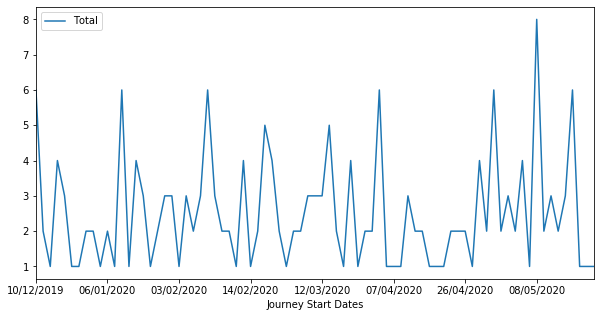

In [82]:
counter_dataframe.plot.line(x="Journey Start Dates", y="Total", figsize = [10,5])